In [1]:
import numpy as np
import torch
from matplotlib.path import Path # Still needed for one PyTorch version strategy
import matplotlib.pyplot as plt

In [2]:
def plot_phantom_views(phantom_base, title, show_yz = False):
        # Get center coordinates
        center_x = phantom_base.shape[0]//2
        center_y = phantom_base.shape[1]//2
        center_z = phantom_base.shape[2]//2

        # Plot the phantom from different views
        plt.figure(figsize=(15, 5))
        if show_yz:
            # Sagittal view (YZ plane, middle of X)
            plt.subplot(131)
            plt.imshow(phantom_base[center_x, :, :], cmap='gray')
            plt.title('Sagittal View (YZ plane)')
            plt.xlabel('Z axis')
            plt.ylabel('Y axis')

            # Coronal view (XZ plane, middle of Y)
            plt.subplot(132)
            plt.imshow(phantom_base[:, center_y, :], cmap='gray', aspect='equal')
            plt.title('Coronal View (XZ plane)')
            plt.xlabel('Z axis')
            plt.ylabel('X axis')
        
            # Axial view (XY plane, middle of Z)
            plt.subplot(133)
            plt.imshow(phantom_base[:, :, center_z], cmap='gray', aspect='equal')
            plt.title('Axial View (XY plane)')
            plt.xlabel('Y axis')
            plt.ylabel('X axis')
        else:
            # Coronal view (XZ plane, middle of Y)
            plt.subplot(121)
            plt.imshow(phantom_base[:, center_y, :], cmap='gray', aspect='equal')
            plt.title('Coronal View (XZ plane)')
            plt.xlabel('Z axis')
            plt.ylabel('X axis')
        
            # Axial view (XY plane, middle of Z)
            plt.subplot(122)
            plt.imshow(phantom_base[:, :, center_z], cmap='gray', aspect='equal')
            plt.title('Axial View (XY plane)')
            plt.xlabel('Y axis')
            plt.ylabel('X axis')

        plt.suptitle(title, fontsize=14)

        # Turn off axis numbers for all subplots
        for ax in plt.gcf().axes:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

In [3]:


# --- Device Configuration for PyTorch ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using PyTorch device: {device}")

# ==============================================================================
# PYTORCH IMPLEMENTED FUNCTIONS
# ==============================================================================

def add_phantom_base_pytorch(base_value, phantom_size_mm=200, phantom_height_mm=52, matrix_size=(182, 64, 182), FOV_xz_mm=300, device=device):
    phantom_base_torch = torch.zeros(matrix_size, dtype=torch.float32, device=device)
    voxel_size_mm = FOV_xz_mm / matrix_size[0]
    cylinder_height_voxels = int(phantom_height_mm / voxel_size_mm)
    cylinder_radius_voxels = int((phantom_size_mm / 2) / voxel_size_mm)

    center_x = matrix_size[0] // 2
    center_y = matrix_size[1] // 2
    center_z = matrix_size[2] // 2
    cylinder_height_half_voxels = cylinder_height_voxels // 2

    # Create coordinate grids
    x = torch.arange(matrix_size[0], device=device).float()
    y = torch.arange(matrix_size[1], device=device).float()
    z = torch.arange(matrix_size[2], device=device).float()

    xx, yy, zz = torch.meshgrid(x, y, z, indexing='ij')

    # Cylinder condition
    mask_xz = (xx - center_x)**2 + (zz - center_z)**2 <= cylinder_radius_voxels**2
    mask_y = torch.abs(yy - center_y) <= cylinder_height_half_voxels

    cylinder_mask = mask_xz & mask_y
    phantom_base_torch[cylinder_mask] = base_value

    return phantom_base_torch, voxel_size_mm

def add_four_cylinders_pytorch(phantom_base_torch, small_radius_mm=20, distance_from_center_mm=40, value=0.5, voxel_size_mm=1.0, device=device):
    result_torch = torch.zeros_like(phantom_base_torch, device=device)
    small_radius_voxels = int(small_radius_mm / voxel_size_mm)
    distance_from_center_voxel = int(distance_from_center_mm / voxel_size_mm)

    s_x, s_y, s_z = phantom_base_torch.shape
    center_x = s_x // 2
    center_y = s_y // 2
    center_z = s_z // 2

    non_zero_y = torch.any(phantom_base_torch != 0, dim=(0, 2))
    if torch.any(non_zero_y):
        y_coords_nonzero = torch.where(non_zero_y)[0]
        base_cylinder_y_min = y_coords_nonzero.min()
        base_cylinder_y_max = y_coords_nonzero.max()
        cylinder_height_voxels = base_cylinder_y_max - base_cylinder_y_min + 1
    else:
        cylinder_height_voxels = s_y
    cylinder_height_half_voxels = cylinder_height_voxels.item() // 2 # .item() to get Python int

    # Create coordinate grids
    x_coords = torch.arange(s_x, device=device).float()
    y_coords = torch.arange(s_y, device=device).float()
    z_coords = torch.arange(s_z, device=device).float()
    xx, yy, zz = torch.meshgrid(x_coords, y_coords, z_coords, indexing='ij')

    # Cylinder 1 (X+)
    mask_xz1 = (xx - (center_x + distance_from_center_voxel))**2 + (zz - center_z)**2 <= small_radius_voxels**2
    # Cylinder 2 (X-)
    mask_xz2 = (xx - (center_x - distance_from_center_voxel))**2 + (zz - center_z)**2 <= small_radius_voxels**2
    # Cylinder 3 (Z+)
    mask_xz3 = (xx - center_x)**2 + (zz - (center_z + distance_from_center_voxel))**2 <= small_radius_voxels**2
    # Cylinder 4 (Z-)
    mask_xz4 = (xx - center_x)**2 + (zz - (center_z - distance_from_center_voxel))**2 <= small_radius_voxels**2

    mask_y_all = torch.abs(yy - center_y) <= cylinder_height_half_voxels

    result_torch[(mask_xz1 & mask_y_all)] = value
    result_torch[(mask_xz2 & mask_y_all)] = value
    result_torch[(mask_xz3 & mask_y_all)] = value
    result_torch[(mask_xz4 & mask_y_all)] = value

    return result_torch * (phantom_base_torch > 0) # Mask with base

def add_phantom_rectangle_pytorch(phantom_base_torch, rect_width_mm, rect_length_mm, x_offset_mm=0, z_offset_mm=0, n_line=1, value1=0.5, value2=0, voxel_size_mm=1.0, device=device):
    rect_phantom_torch = torch.zeros_like(phantom_base_torch, device=device)

    rect_width_voxels = int(rect_width_mm / voxel_size_mm)
    rect_length_voxels = int(rect_length_mm / voxel_size_mm)
    x_offset_voxels = int(x_offset_mm / voxel_size_mm)
    z_offset_voxels = int(z_offset_mm / voxel_size_mm)

    s_x, s_y, s_z = phantom_base_torch.shape
    center_x_base = s_x // 2
    center_y_base = s_y // 2
    center_z_base = s_z // 2

    center_x = center_x_base + x_offset_voxels
    center_z = center_z_base + z_offset_voxels

    non_zero_y = torch.any(phantom_base_torch != 0, dim=(0, 2))
    if torch.any(non_zero_y):
        y_coords_nonzero = torch.where(non_zero_y)[0]
        base_cylinder_y_min = y_coords_nonzero.min()
        base_cylinder_y_max = y_coords_nonzero.max()
        cylinder_height_voxels = base_cylinder_y_max - base_cylinder_y_min + 1
    else:
        cylinder_height_voxels = s_y

    x_start = center_x - rect_width_voxels // 2
    x_end = center_x + rect_width_voxels // 2
    z_start = center_z - rect_length_voxels // 2
    z_end = center_z + rect_length_voxels // 2

    y_start = center_y_base - cylinder_height_voxels.item() // 2
    y_end_val = y_start + cylinder_height_voxels.item()

    # Create coordinate grids for x to handle stripes
    x_coords_stripe = torch.arange(s_x, device=device).float()

    if n_line == 0:
        rect_phantom_torch[x_start:x_end, y_start:y_end_val, z_start:z_end] = value1
    else:
        section_width_voxels = rect_width_voxels // n_line
        for i in range(n_line):
            section_x_start = x_start + i * section_width_voxels
            section_x_end = x_start + (i + 1) * section_width_voxels if i < n_line - 1 else x_end
            current_value = value1 if i % 2 == 0 else value2
            rect_phantom_torch[section_x_start:section_x_end, y_start:y_end_val, z_start:z_end] = current_value

    return rect_phantom_torch * (phantom_base_torch > 0) # Mask with base

def add_phantom_ring_pytorch(phantom_base_torch, outer_rad_mm, inner_rad_mm, value, phantom_height_mm, matrix_size, FOV_xz_mm, device=device):
    # Reuses the PyTorch base creation
    large_cylinder_torch, _ = add_phantom_base_pytorch(1, outer_rad_mm, phantom_height_mm, matrix_size, FOV_xz_mm, device=device)
    small_cylinder_torch, _ = add_phantom_base_pytorch(1, inner_rad_mm, phantom_height_mm, matrix_size, FOV_xz_mm, device=device)
    ring_phantom_torch = (large_cylinder_torch - small_cylinder_torch) * value
    return ring_phantom_torch


def add_rotated_cubes_pytorch(phantom_base_torch, cube_size_mm, voxel_size_mm, rotation_angle=np.pi/6, cube1_value=1, cube2_value=2, device=device):
    cube_size_voxels = int(np.floor(cube_size_mm / voxel_size_mm))
    cube_phantom_torch = torch.zeros_like(phantom_base_torch, device=device)

    s_x, s_y, s_z = phantom_base_torch.shape
    center_x = s_x // 2
    center_y = s_y // 2
    center_z = s_z // 2

    phantom_size_x = s_x
    cylinder_radius_voxels = phantom_size_x // 4

    # Define cube vertices (NumPy for Path compatibility)
    cube1_center_x_np = center_x - cylinder_radius_voxels // 2
    cube1_center_z_np = center_z - cylinder_radius_voxels // 2
    vertices1_xz_np = np.array([
        [cube1_center_x_np - cube_size_voxels / 2, cube1_center_z_np - cube_size_voxels / 2],
        [cube1_center_x_np + cube_size_voxels / 2, cube1_center_z_np - cube_size_voxels / 2],
        [cube1_center_x_np + cube_size_voxels / 2, cube1_center_z_np + cube_size_voxels / 2],
        [cube1_center_x_np - cube_size_voxels / 2, cube1_center_z_np + cube_size_voxels / 2]
    ])

    cube2_center_x_np = center_x - cylinder_radius_voxels // 2
    cube2_center_z_np = center_z + cylinder_radius_voxels // 2
    vertices2_xz_np = np.array([
        [cube2_center_x_np - cube_size_voxels / 2, cube2_center_z_np - cube_size_voxels / 2],
        [cube2_center_x_np + cube_size_voxels / 2, cube2_center_z_np - cube_size_voxels / 2],
        [cube2_center_x_np + cube_size_voxels / 2, cube2_center_z_np + cube_size_voxels / 2],
        [cube2_center_x_np - cube_size_voxels / 2, cube2_center_z_np + cube_size_voxels / 2]
    ])

    rotation_matrix_np = np.array([
        [np.cos(rotation_angle), -np.sin(rotation_angle)],
        [np.sin(rotation_angle), np.cos(rotation_angle)]
    ])

    center_point1_np = np.array([cube1_center_x_np, cube1_center_z_np])
    rotated_vertices1_np = np.array([
        np.dot(rotation_matrix_np, (vertex - center_point1_np)) + center_point1_np
        for vertex in vertices1_xz_np
    ])

    center_point2_np = np.array([cube2_center_x_np, cube2_center_z_np])
    rotated_vertices2_np = np.array([
        np.dot(rotation_matrix_np, (vertex - center_point2_np)) + center_point2_np
        for vertex in vertices2_xz_np
    ])

    y_start = center_y - cube_size_voxels // 2
    y_end = center_y + cube_size_voxels // 2

    # Create meshgrid points on CPU for Path, then convert mask to tensor
    x_coords_np, z_coords_np = np.meshgrid(np.arange(s_x), np.arange(s_z), indexing='ij')
    points_np = np.column_stack((x_coords_np.ravel(), z_coords_np.ravel()))

    square_path1 = Path(rotated_vertices1_np)
    square_path2 = Path(rotated_vertices2_np)

    mask1_np = square_path1.contains_points(points_np).reshape(s_x, s_z)
    mask2_np = square_path2.contains_points(points_np).reshape(s_x, s_z)

    mask1_torch = torch.from_numpy(mask1_np).to(device)
    mask2_torch = torch.from_numpy(mask2_np).to(device)

    for y_idx in range(y_start, y_end):
        cube_phantom_torch[:, y_idx, :] = mask1_torch.float() * cube1_value + mask2_torch.float() * cube2_value

    return cube_phantom_torch * (phantom_base_torch > 0)


# ==============================================================================
# MAIN EXECUTION (Example Usage)
# ==============================================================================



# --- PyTorch Version ---

# To use with other NumPy-based code, convert the PyTorch tensor back to NumPy:
# combined_phantom_pytorch_np = combined_phantom_pytorch.cpu().numpy()
# print("PyTorch combined phantom converted to NumPy. Shape:", combined_phantom_pytorch_np.shape)

# You can now use combined_phantom_numba or combined_phantom_pytorch_np
# For example, to check if they are approximately equal (if all values are the same):
# if np.allclose(combined_phantom_numba, combined_phantom_pytorch.cpu().numpy()):
# print("\nNumba and PyTorch versions are approximately equal.")
# else:
# print("\nNumba and PyTorch versions differ.")

Using PyTorch device: cuda


In [4]:

# --- Parameters ---
base_rad_mm = 200
base_height_mm = 52
FOV_xz_mm = 300
matrix_size_param = (900, 300, 900) # Larger for more noticeable performance difference
cube_size_mm_param = 35
ring_outer_rad_mm = 185
ring_inner_rad_mm = 170
small_cylinder_rad_mm = 4
small_cylinder_dist_mm = 70

In [11]:

print("\n--- Running PyTorch Version ---")
phantom_base_pt, voxel_size_pt = add_phantom_base_pytorch(1, base_rad_mm, base_height_mm, matrix_size_param, FOV_xz_mm, device=device)
print("PyTorch base phantom created.")

phantom_cube_pt = add_rotated_cubes_pytorch(phantom_base_pt, cube_size_mm_param, voxel_size_pt, np.pi / 12, -1, -1, device=device)
print("PyTorch rotated cubes created.")

phantom_ring_pt = add_phantom_ring_pytorch(phantom_base_pt, ring_outer_rad_mm, ring_inner_rad_mm, -1, base_height_mm, matrix_size_param, FOV_xz_mm, device=device)
print("PyTorch ring created.")

phantom_small_cylinders_pt = add_four_cylinders_pytorch(phantom_base_pt, small_cylinder_rad_mm, small_cylinder_dist_mm, -1, voxel_size_pt, device=device)
print("PyTorch four cylinders created.")

phantom_lines1_pt = add_phantom_rectangle_pytorch(phantom_base_pt, 10, 100, x_offset_mm=10, n_line=9, value1=0, value2=-1, voxel_size_mm=voxel_size_pt, device=device)
phantom_lines2_pt = add_phantom_rectangle_pytorch(phantom_base_pt, 20, 100, x_offset_mm=30, n_line=9, value1=0, value2=-1, voxel_size_mm=voxel_size_pt, device=device)
phantom_lines3_pt = add_phantom_rectangle_pytorch(phantom_base_pt, 15, 30, x_offset_mm=55, z_offset_mm=25, n_line=9, value1=0, value2=-1, voxel_size_mm=voxel_size_pt, device=device)
phantom_lines4_pt = add_phantom_rectangle_pytorch(phantom_base_pt, 4, 15, x_offset_mm=50, z_offset_mm=-25, n_line=4, value1=0, value2=-1, voxel_size_mm=voxel_size_pt, device=device)
print("PyTorch rectangles created.")

combined_phantom_pytorch = (phantom_base_pt + phantom_cube_pt + phantom_ring_pt + phantom_small_cylinders_pt +
                             phantom_lines1_pt + phantom_lines2_pt + phantom_lines3_pt + phantom_lines4_pt)
print("PyTorch combined phantom created. Shape:", combined_phantom_pytorch.shape, "Device:", combined_phantom_pytorch.device)


--- Running PyTorch Version ---
PyTorch base phantom created.
PyTorch rotated cubes created.
PyTorch ring created.
PyTorch four cylinders created.
PyTorch rectangles created.
PyTorch combined phantom created. Shape: torch.Size([900, 300, 900]) Device: cuda:0


In [12]:
# Convert combined phantom to CPU numpy array and free GPU memory
combined_phantom = combined_phantom_pytorch.cpu().numpy()
del phantom_base_pt, phantom_cube_pt, phantom_ring_pt, phantom_small_cylinders_pt
del phantom_lines1_pt, phantom_lines2_pt, phantom_lines3_pt, phantom_lines4_pt
del combined_phantom_pytorch
torch.cuda.empty_cache()


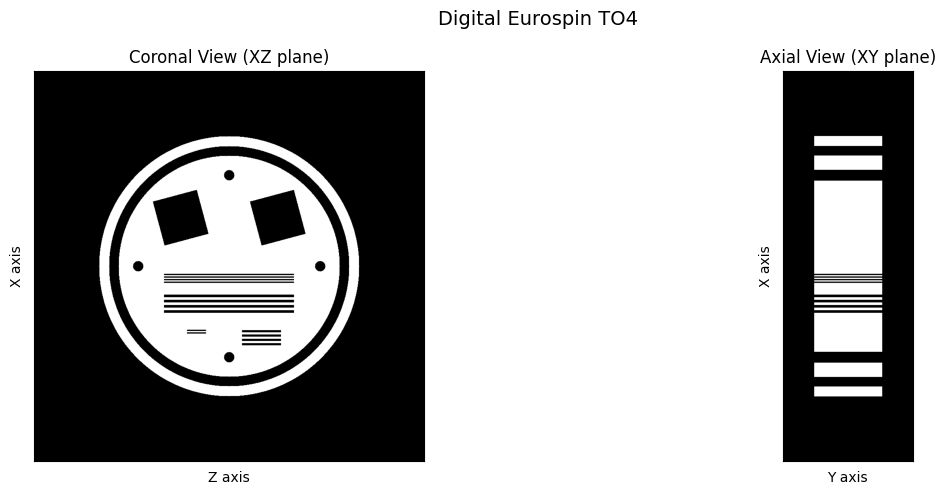

In [14]:
plot_phantom_views(combined_phantom,'Digital Eurospin TO4')

In [16]:
import nibabel as nib

# Create a NIfTI image from the phantom array
nifti_img = nib.Nifti1Image(combined_phantom, affine=np.eye(4))

# Save the NIfTI image
nib.save(nifti_img, 'synthetic_phantom.nii.gz')

print(f"Phantom saved as synthetic_phantom.nii.gz with shape: {combined_phantom.shape}")

Phantom saved as synthetic_phantom.nii.gz with shape: (900, 300, 900)
